In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_machine_learning.datasets import ad_hoc_data
from itertools import chain, combinations
import random

In [2]:
from qiskit_aer import AerSimulator
sim = AerSimulator()

# Ad Hoc Data

In [3]:
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )

In [4]:
def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

    plt.figure(figsize=(5, 5))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap="RdBu",
        extent=[0, 2 * np.pi, 0, 2 * np.pi],
    )
    plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")
    plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")
    plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")
    plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()

# Feature Map

In [5]:
def powerset(iterable, size):
    s = list(range(len(iterable)))
    return chain.from_iterable(combinations(s, r) for r in range(size + 1))

In [6]:
def feature_map_custom(fm, x, reps):
    list_of_set = list(powerset(x, 2))

    for _ in range(reps):
        for i in range(len(x)):
            fm.h(i)
        for l in list_of_set:
            if len(l) == 0:
                continue
            if len(l) == 1:
                fm.p(-2 * x[l[0]], l[0])
            else:
                (i, j) = l
                fm.cx(i, j)
                fm.p(-2 *(np.pi-x[i])*(np.pi-x[j]), j)
                fm.cx(i, j)
        fm.barrier()
        

# Ansatz

In [7]:
def ansatz_custom_other(ansatz, theta, nbr_of_qubits, reps):
    for i in range(reps+1):
        for j in range(0, nbr_of_qubits*2, 2):
            ansatz.ry(theta[(nbr_of_qubits*2)*i+j], int(j/2))
            ansatz.rz(theta[(nbr_of_qubits*2)*i+j+1], int(j/2))
        if i != reps:
            for j in range(nbr_of_qubits-1):
                ansatz.cz(j, j+1)
            if nbr_of_qubits != 2:
                ansatz.cz(nbr_of_qubits-1, 0)

# Implementation

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [9]:
def single_circuit_evaluation(x, theta, reps_thetas, shots):
    size = len(x)
    qc = QuantumCircuit(size)
    feature_map_custom(fm = qc, x = x, reps = 2)
    ansatz_custom_other(ansatz = qc, theta = theta, nbr_of_qubits = size, reps = reps_thetas)
    qc.measure_all()
    job = sim.run(qc, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

In [10]:
def compute_empirical_risk(train_features, train_labels, w, reps_thetas, shots):
    r = shots/10
    y = 0
    theta = w[:-1]
    b = w[-1]

    empirical_risk = 0
    for i in range(len(train_labels)):
        py_empirical = 0
        counts = single_circuit_evaluation(train_features[i], theta, reps_thetas, shots)
        
        p_0 = (counts.get("00", 0)+counts.get("11", 0))/shots
        p_1 = (counts.get("01", 0)+counts.get("10", 0))/shots
        if train_labels[i] == 1:
            py_empirical = p_1
            y = 1
        else:
            py_empirical = p_0
            y = -1
        top = np.sqrt(r)*(0.5-(py_empirical-0.5*(y*b)))
        bottom = np.sqrt(2*(1-py_empirical)*py_empirical)
        empirical_risk += sigmoid(top/bottom)   
    empirical_risk /= len(train_labels)
    return empirical_risk


In [11]:
def compute_grad(train_features, train_labels, w, ck, reps_thetas, shots):
    deltak = np.random.choice([-1, 1], len(w))

    lossplus = compute_empirical_risk(train_features, train_labels, w+ck*deltak, reps_thetas, shots)
    lossminus = compute_empirical_risk(train_features, train_labels, w-ck*deltak, reps_thetas, shots)

    avg_loss = (lossplus+lossminus)/2
    grad = (lossplus-lossminus)/(2*ck*(deltak))
    
    return grad, avg_loss

In [12]:
def init_a(train_features, train_labels, w, c, A, alpha, reps_thetas, shots):
    target_magnitudes = 0.15
    steps = 25
    avg_magnitudes = 0

    for _ in range(steps):
        grad, _ = compute_grad(train_features, train_labels, w, c, reps_thetas, shots)
        avg_magnitudes += np.abs(grad)

    avg_magnitudes /= steps
        
    return (target_magnitudes*(A**alpha) / avg_magnitudes)

In [13]:
def do_spsa(train_features, train_labels, w, reps_thetas, shots, N=250, alpha = 0.602, gamma = 0.101,):
    A = N * 0.01
    c = 0.2
    a = init_a(train_features, train_labels, w, c, A, alpha, reps_thetas, shots)
    print("a: ", a)
    print("c: ", c)

    loss_list = []

    min_w = w
    min_loss = 1

    for k in range(1, N):
        ak = a / (A + k)**alpha
        ck = c / (k**gamma)
        gk, loss  = compute_grad(train_features, train_labels, w, ck, reps_thetas, shots)

        loss_list.append(loss)
        
        if loss < min_loss:
            min_loss = loss
            min_w = w

        w = w - ak*gk

    return min_w, loss_list

In [14]:
def training_phase(train_features, train_labels, reps_thetas, shots=2000):
    theta = [0] * (2*len(train_features[0]) * (reps_thetas+1))
    b = 0
    
    w = theta + [b]
    theta, loss_list = do_spsa(train_features, train_labels, w, reps_thetas, shots=shots)
    return theta, loss_list

In [15]:
def classification_phase(test_features, test_labels, theta_optimal, reps_thetas, shots=10000):
    predictions = []
    for i in range(len(test_features)):
        counts = single_circuit_evaluation(test_features[i], theta_optimal, reps_thetas, shots)
        p_0 = (counts.get("00", 0)+counts.get("11", 0))/shots
        p_1 = (counts.get("01", 0)+counts.get("10", 0))/shots
        if p_0 > p_1:
            predictions.append(-1)
        else:
            predictions.append(1)
    
    success_rate = np.sum(np.equal(predictions, test_labels))/len(test_labels)
    return predictions, success_rate

In [16]:
def run_plot():
    train_features, train_labels, test_features, test_labels, _ = ad_hoc_data(
        training_size=40, test_size=800, n=2, gap=0.3, one_hot=False, include_sample_total=True
    )
    train_labels = np.where(train_labels == 0, -1, 1)
    test_labels = np.where(test_labels == 0, -1, 1)

    success_rates = []

    for reps_thetas in range(5):
        theta_optimal, loss_list = training_phase(train_features, train_labels, reps_thetas)

        for i in range(20):
            used_test_features = np.concatenate((test_features[i*20:(i+1)*20], test_features[400+i*20:400+(i+1)*20]))
            used_test_labels = np.concatenate((test_labels[i*20:(i+1)*20], test_labels[400+i*20:400+(i+1)*20]))


            predict_labels, success_rate = classification_phase(used_test_features, used_test_labels, theta_optimal, reps_thetas)
            success_rates.append(success_rate)
            print("Success rate for ", reps_thetas, " is ", success_rate)

    return success_rates

In [17]:
print("First dataset")
success_rates_1 = run_plot()

First dataset
a:  [1.70257734 1.70257734 1.70257734 1.70257734 1.70257734]
c:  0.2
Success rate for  0  is  0.75
Success rate for  0  is  0.625
Success rate for  0  is  0.725
Success rate for  0  is  0.725
Success rate for  0  is  0.8
Success rate for  0  is  0.7
Success rate for  0  is  0.7
Success rate for  0  is  0.775
Success rate for  0  is  0.75
Success rate for  0  is  0.775
Success rate for  0  is  0.8
Success rate for  0  is  0.825
Success rate for  0  is  0.8
Success rate for  0  is  0.875
Success rate for  0  is  0.7
Success rate for  0  is  0.775
Success rate for  0  is  0.85
Success rate for  0  is  0.8
Success rate for  0  is  0.775
Success rate for  0  is  0.775


/var/folders/gw/m_z3771914q1lhfv4x8_8wxm0000gn/T/ipykernel_27383/1887691553.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  empirical_risk += sigmoid(top/bottom)


a:  [0.96245318 0.96245318 0.96245318 0.96245318 0.96245318 0.96245318
 0.96245318 0.96245318 0.96245318]
c:  0.2
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  0.975
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
a:  [0.8848156 0.8848156 0.8848156 0.8848156 0.8848156 0.8848156 0.8848156
 0.8848156 0.8848156 0.8848156 0.8848156 0.8848156 0.8848156]
c:  0.2
Success rate for  2  is  1.0
Success rate for  2  is  1.0
Success rate for  2  is  0.975
Success rate for  2  is  1.0
Success rate for  2  is  1.0
Success rate

In [18]:
print("Second dataset")
success_rates_2 = run_plot()

Second dataset
a:  [1.51098097 1.51098097 1.51098097 1.51098097 1.51098097]
c:  0.2
Success rate for  0  is  0.65
Success rate for  0  is  0.75
Success rate for  0  is  0.75
Success rate for  0  is  0.775
Success rate for  0  is  0.675
Success rate for  0  is  0.75
Success rate for  0  is  0.6
Success rate for  0  is  0.825
Success rate for  0  is  0.675
Success rate for  0  is  0.725
Success rate for  0  is  0.775
Success rate for  0  is  0.65
Success rate for  0  is  0.775
Success rate for  0  is  0.725
Success rate for  0  is  0.7
Success rate for  0  is  0.725
Success rate for  0  is  0.9
Success rate for  0  is  0.75
Success rate for  0  is  0.675
Success rate for  0  is  0.675
a:  [0.81650736 0.81650736 0.81650736 0.81650736 0.81650736 0.81650736
 0.81650736 0.81650736 0.81650736]
c:  0.2
Success rate for  1  is  0.95
Success rate for  1  is  0.975
Success rate for  1  is  1.0
Success rate for  1  is  0.95
Success rate for  1  is  1.0
Success rate for  1  is  0.95
Success rate fo

In [21]:
print("Third dataset")
success_rates_3 = run_plot()

Third dataset
a:  [1.9297158 1.9297158 1.9297158 1.9297158 1.9297158]
c:  0.2
Success rate for  0  is  0.7
Success rate for  0  is  0.675
Success rate for  0  is  0.775
Success rate for  0  is  0.7
Success rate for  0  is  0.775
Success rate for  0  is  0.75
Success rate for  0  is  0.675
Success rate for  0  is  0.675
Success rate for  0  is  0.625
Success rate for  0  is  0.725
Success rate for  0  is  0.825
Success rate for  0  is  0.725
Success rate for  0  is  0.675
Success rate for  0  is  0.6
Success rate for  0  is  0.725
Success rate for  0  is  0.6
Success rate for  0  is  0.725
Success rate for  0  is  0.8
Success rate for  0  is  0.725
Success rate for  0  is  0.55
a:  [1.2657622 1.2657622 1.2657622 1.2657622 1.2657622 1.2657622 1.2657622
 1.2657622 1.2657622]
c:  0.2
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Success rate for  1  is  1.0
Succes

/var/folders/gw/m_z3771914q1lhfv4x8_8wxm0000gn/T/ipykernel_27383/1887691553.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  empirical_risk += sigmoid(top/bottom)


Success rate for  2  is  0.975
Success rate for  2  is  0.95
Success rate for  2  is  0.9
Success rate for  2  is  0.95
Success rate for  2  is  0.925
Success rate for  2  is  0.975
Success rate for  2  is  0.925
Success rate for  2  is  0.9
Success rate for  2  is  0.9
Success rate for  2  is  1.0
Success rate for  2  is  0.925
Success rate for  2  is  0.925
Success rate for  2  is  0.975
Success rate for  2  is  0.925
Success rate for  2  is  0.95
Success rate for  2  is  0.925
Success rate for  2  is  0.9
Success rate for  2  is  0.975
Success rate for  2  is  0.975
Success rate for  2  is  0.925
a:  [0.96713758 0.96713758 0.96713758 0.96713758 0.96713758 0.96713758
 0.96713758 0.96713758 0.96713758 0.96713758 0.96713758 0.96713758
 0.96713758 0.96713758 0.96713758 0.96713758 0.96713758]
c:  0.2
Success rate for  3  is  1.0
Success rate for  3  is  1.0
Success rate for  3  is  1.0
Success rate for  3  is  1.0
Success rate for  3  is  1.0
Success rate for  3  is  1.0
Success rate for

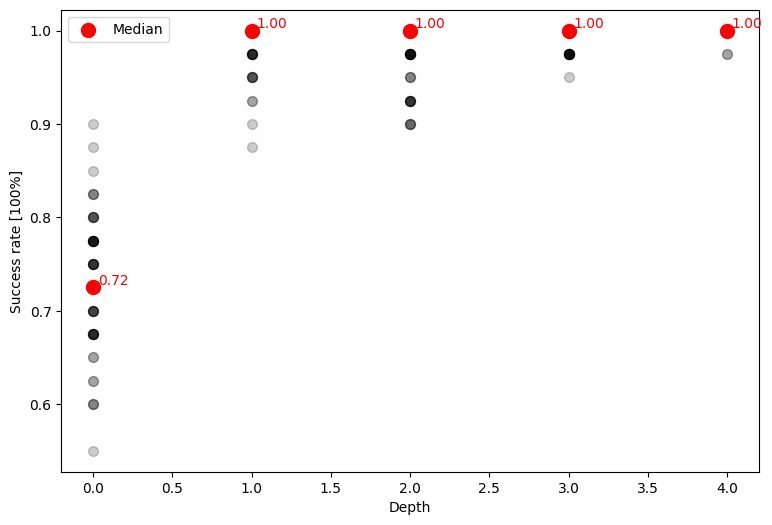

In [22]:
succes_rates_layer_0 = success_rates_1[:20] + success_rates_2[:20] + success_rates_3[:20]
succes_rates_layer_1 = success_rates_1[20:40] + success_rates_2[20:40] + success_rates_3[20:40]
succes_rates_layer_2 = success_rates_1[40:60] + success_rates_2[40:60] + success_rates_3[40:60]
succes_rates_layer_3 = success_rates_1[60:80] + success_rates_2[60:80] + success_rates_3[60:80]
succes_rates_layer_4 = success_rates_1[80:] + success_rates_2[80:] + success_rates_3[80:]

layer_0 = [0] * 20 * 3
layer_1 = [1] * 20 * 3 
layer_2 = [2] * 20 * 3
layer_3 = [3] * 20 * 3
layer_4 = [4] * 20 * 3

layers = [layer_0, layer_1, layer_2, layer_3, layer_4]
success_rates = [succes_rates_layer_0, succes_rates_layer_1, succes_rates_layer_2, succes_rates_layer_3, succes_rates_layer_4]

plt.figure(figsize=(9, 6))

# Plot the scatter plots
for layer, success_rate in zip(layers, success_rates):
    plt.scatter(layer, success_rate, alpha=0.2, s=50, c='black')

# Calculate and plot the medians
depths = [0, 1, 2, 3, 4]
medians = [np.median(succes_rates_layer_0), np.median(succes_rates_layer_1), 
           np.median(succes_rates_layer_2), np.median(succes_rates_layer_3), 
           np.median(succes_rates_layer_4)]

plt.scatter(depths, medians, color='red', s=100, label='Median')

# Annotate median values
for depth, median in zip(depths, medians):
    plt.text(depth+0.03, median, f'{median:.2f}', ha='left', va='bottom', color='red')

plt.xlabel("Depth")
plt.ylabel("Success rate [100%]")
plt.legend()
plt.show()